In [11]:
#HeLLO welcome to my legal assistant
# If you want to run the the model training process

# recommended : run cells one after the other to track progress, or run click run all to run entire notebook.
# Running entire note book if you are using a cpu might be slower to see result

In [12]:
#loading datasets
# datasets merged into one called merged_contracts.csv

In [13]:
import json
import os
import pandas as pd

file_paths = [
    "../datacleaning/datasets/employment/emp1.json",
    "../datacleaning/datasets/NDA/NDA1.json",
    "../datacleaning/datasets/Partnership/part1.json",
    "../datacleaning/datasets/SLA/SLA1.json",
    "../datacleaning/datasets/VEND/vendor1.json",
]

all_data = []
for path in file_paths:
    print(f"Reading: {path}")
    if not os.path.exists(path):
        print(" File not found!")
        continue
    with open(path, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
            if isinstance(data, list):
                all_data.extend(data)
            else:
                all_data.append(data)
        except json.JSONDecodeError:
            print("⚠️ Bad JSON file skipped.")
            continue

df = pd.DataFrame(all_data)
if not {"text", "label"}.issubset(df.columns):
    raise ValueError(f"Missing required columns! Found: {df.columns.tolist()}")

# Save to CSV
df.to_csv("merged_contracts.csv", index=False, encoding="utf-8")





Reading: ../datacleaning/datasets/employment/emp1.json
Reading: ../datacleaning/datasets/NDA/NDA1.json
Reading: ../datacleaning/datasets/Partnership/part1.json
Reading: ../datacleaning/datasets/SLA/SLA1.json
Reading: ../datacleaning/datasets/VEND/vendor1.json


In [14]:
#data cleaning done here. Stripping off characters done here, including white spaces
# saved into merged_contracts_cleaned.csv

In [15]:
df = df.dropna(subset=["text", "label"])
df = df[df["text"].str.strip() != ""]

df["text"] = df["text"].str.strip()
df["label"] = df["label"].str.strip()

df = df[["text", "label"]]

df.to_csv("merged_contracts_cleaned.csv", index=False, encoding="utf-8")
print("✅ Cleaned data saved to merged_contracts_cleaned.csv")






✅ Cleaned data saved to merged_contracts_cleaned.csv


In [16]:
# Data exploration done here, to keep labels more accurate, labels are setup properly here 
# eg. SLA and sla might be read as two seperate labels, mapping them is very important

#when you ran df["label"].unique(), you might see this issue if its in your data set

In [17]:
import pandas as pd

df = pd.read_csv("../datacleaning/merged_contracts_cleaned.csv")

label_mapping = {
    "NDA": "Non-disclosure Agreement",
    "Non-disclosure": "Non-disclosure Agreement",
    "Confidentiality Agreement": "Non-disclosure Agreement",
    "Non-Disclosure Agreement":"Non-disclosure Agreement",
    "employment contract": "Employment",
    "partnership agreement": "Partnership",
    "service level agreement": "SLA",
    "vendor agreement": "Vendor"
}

df["label"] = df["label"].replace(label_mapping)

df.to_csv("contracts_clean.csv", index=False)

df["label"].unique()




array(['Employment', 'Non-disclosure Agreement', 'Partnership', 'SLA',
       'Vendor'], dtype=object)

In [18]:
# dataset splitting done here
# into train, test and validation. using all your dataset to train means you would need some other to test and validate
# dont train model and test by same dataset used in training

In [19]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv("../datacleaning/contracts_clean.csv")

# Split into train + temp
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

# Split temp into validation + test
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Save splits
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

print("✅ Done! Dataset split into:")
print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))


✅ Done! Dataset split into:
Train: 234
Validation: 50
Test: 51


In [20]:
# Label encoding
# Label encoding helps us assign cone values sort of to the classes or the label
# the labels is the type of document or contract in our case

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = le.fit_transform(train_df['label'])
val_labels = le.transform(val_df['label'])
test_labels = le.transform(test_df['label'])



In [22]:
# tokenizing datasets into numbers

In [23]:
# Step 1: Import the tokenizer
from transformers import AutoTokenizer

model_name = "nlpaueb/legal-bert-base-uncased" 

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Step 3: Now encode your texts
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True, max_length=512, return_tensors="pt")
val_encodings = tokenizer(list(val_df['text']), truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True, max_length=512, return_tensors="pt")

In [24]:
import torch
from torch.utils.data import Dataset

class ContractDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels  

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
     
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item



In [25]:
train_dataset = ContractDataset(train_encodings, train_labels)
val_dataset = ContractDataset(val_encodings, val_labels)
test_dataset = ContractDataset(test_encodings, test_labels)



In [26]:
from torch.utils.data import DataLoader

batch_size = 4  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

batch = next(iter(train_loader))
print(batch.keys())           # dict_keys(['input_ids', 'attention_mask', 'labels'])
print(batch['input_ids'].shape)  # e.g., torch.Size([4, 512])
print(batch['labels'])           # e.g., tensor([0, 1, 2, 0])




dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
torch.Size([4, 512])
tensor([3, 3, 3, 3])


C:\Users\PhilemonGyamfi\AppData\Local\Temp\ipykernel_70932\4283650326.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [27]:
# loading raw legal bert model to start fine tuning
# running this cell for the first time might take a while, internet speed is a dependency here
# the model downloads on first run 

In [28]:
import torch
from torch.optim import AdamW  # ✅ correct import
from transformers import AutoModelForSequenceClassification

num_labels = len(le.classes_)

model = AutoModelForSequenceClassification.from_pretrained(
    "nlpaueb/legal-bert-base-uncased",
    num_labels=num_labels
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)  # ✅ now it works


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()

for batch in train_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)


outputs = model(input_ids=input_ids, attention_mask=attention_mask)
logits = outputs.logits
loss = loss_fn(logits, labels)



C:\Users\PhilemonGyamfi\AppData\Local\Temp\ipykernel_70932\4283650326.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


KeyboardInterrupt: 

In [ ]:
optimizer.zero_grad()   # clear previous gradients
loss.backward()         # compute new gradients
optimizer.step()        # update model weights


In [ ]:
model.train()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
epochs = 3  # or more depending on dataset size

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Compute loss
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/3, Loss: 1.2480
Epoch 2/3, Loss: 0.2518
Epoch 3/3, Loss: 0.1191


In [ ]:
model.save_pretrained("legalbert-contracts")
tokenizer.save_pretrained("legalbert-contracts")


('legalbert-contracts\\tokenizer_config.json',
 'legalbert-contracts\\special_tokens_map.json',
 'legalbert-contracts\\vocab.txt',
 'legalbert-contracts\\added_tokens.json',
 'legalbert-contracts\\tokenizer.json')

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total:.4f}")



C:\Users\PhilemonGyamfi\AppData\Local\Temp\ipykernel_68296\709338502.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Test Accuracy: 0.2353


: 

In [58]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle


model = AutoModelForSequenceClassification.from_pretrained("../datacleaning/legalbert-contracts")
tokenizer = AutoTokenizer.from_pretrained("../datacleaning/legalbert-contracts")
model.eval()

# Load your test dataset
test_df = pd.read_csv("test.csv")

# Encode labels if not already
le = LabelEncoder()
le.fit(test_df['label'])  
y_true = le.transform(test_df['label'])

# Tokenize test texts
inputs = tokenizer(
    test_df['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

# Generate predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    y_pred = torch.argmax(logits, dim=1).numpy()

# Map predicted indices back to labels
pred_labels = le.inverse_transform(y_pred)

# Save predictions
test_df['predicted_label'] = pred_labels
test_df.to_csv("test_predictions.csv", index=False)
print("✅ Predictions saved to test_predictions.csv")


# save encodings
with open("le.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ LabelEncoder saved as le.pkl") 


✅ Predictions saved to test_predictions.csv
✅ LabelEncoder saved as le.pkl


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')  # handles imbalanced classes

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted F1-score: {f1:.4f}")

print("\nPer-class report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))


Accuracy: 0.9804
Weighted F1-score: 0.9801

Per-class report:
                          precision    recall  f1-score   support

              Employment       1.00      0.88      0.93         8
Non-disclosure Agreement       1.00      1.00      1.00        10
             Partnership       1.00      1.00      1.00         8
                     SLA       1.00      1.00      1.00        13
                  Vendor       0.92      1.00      0.96        12

                accuracy                           0.98        51
               macro avg       0.98      0.97      0.98        51
            weighted avg       0.98      0.98      0.98        51



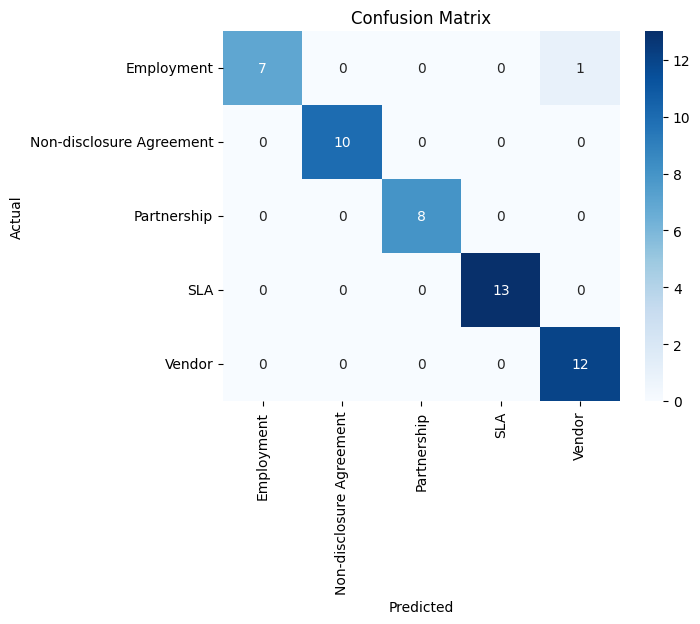

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [59]:
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
        pred_id = torch.argmax(logits, dim=1).item()
    label = le.inverse_transform([pred_id])[0]
    return label

sample_text = """


GENERAL PARTNERSHIP AGREEMENT
    This GENERAL PARTNERSHIP AGREEMENT is made and entered into as of November 5, 2024,
    by and between Eleanor Vance and Julian Santos for operating a specialty coffee roastery and café.
    The partners agree on capital contributions, profit sharing, and management responsibilities.
"""
print("Predicted label:", predict(sample_text))


Predicted label: Partnership


In [62]:
%pip install onnx onnxruntime


  Using cached onnx-1.19.0-cp313-cp313-win_amd64.whl.metadata (7.2 kB)
  Using cached onnxruntime-1.22.1-cp313-cp313-win_amd64.whl.metadata (5.1 kB)
  Using cached protobuf-6.32.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached ml_dtypes-0.5.3-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
  Using cached pyreadline3-3.5.4-py3-none-any.whl.metadata (4.7 kB)
Using cached onnx-1.19.0-cp313-cp313-win_amd64.whl (16.5 MB)
Using cached onnxruntime-1.22.1-cp313-cp313-win_amd64.whl (12.7 MB)
Using cached protobuf-6.32.0-cp310-abi3-win_amd64.whl (435 kB)
Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
Using cached humanfriendly-10.0-py2.py3-none-any.whl (86 kB)
Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
Using cached ml_dtypes-0.5.3-cp31

In [64]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

MODEL_NAME = "../datacleaning/legalbert-contracts"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()

# Dummy input
sample_text = "This is a sample contract."
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Export with dynamic axes
torch.onnx.export(
    model,
    (inputs['input_ids'],),
    "legalbert.onnx",
    input_names=['input_ids'],
    output_names=['logits'],
    opset_version=14,
    dynamic_axes={
        'input_ids': {0: 'batch_size', 1: 'seq_len'},
        'logits': {0: 'batch_size'}
    }
)
print("✅ Model exported to legalbert.onnx with dynamic axes")


C:\Users\PhilemonGyamfi\AppData\Local\Temp\ipykernel_70932\327419594.py:14: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ Model exported to legalbert.onnx with dynamic axes
